# Optimizing X-Vector Speaker Diarization for Low-Resourced Sarawak Malay Dialect using Pseudolabels, Speech Concatenation and Transfer Learning 

Speaker diarization plays a vital role in speech transcription involving conversations as it improves the transcribed content’s accuracy, comprehension, and usability. By having a speech transcription diarized, the conversation data has a more structured presentation, allowing for a variety of applications that rely on accurate speaker attribution. Even so, speaker diarization is a field that has been less explored for low-resourced languages, as current resources that have been optimized and applied in speaker diarization are mostly for more developed and well-resourced languages, such as English, Spanish or French.

The research questions outlined in the x-vectors speaker diarization model optimization framework in the figure below are as listed:

- RQ1: How to optimize the speaker diarization model for an under-resourced language (Sarawak Malay)? 

- RQ2: What are the performances of the proposed optimization approach and audio concatenation approach (with all experiment steps included)?

![alt text](Picture1.png "Title")

In this notebook, we propose an approach to use dataset enrichment by concatenation of speech and pseudo-labelled speech data to perform self-training on the x-vector models to improve diarization accuracy. The proposed method uses almost 13 hours Sarawak Malay unlabeled conversational speech corpus obtained from the Kalaka: Language Map of Malaysia website for training, as well as 1 hour and 26 minutes of manually labeled Sarawak Malay speech data for testing and evaluation. We demonstrate how speaker diarization models can be optimized with the pseudo-labeled enriched Sarawak Malay conversational data.

To run this notebook on a local machine, it is highly recommended to have a GPU equivalent of Google Colab's GPU (RTX3060) and at least 16 gigabytes of RAM installed. This notebook was run on an RTX4060 machine with 16 gigabytes of RAM installed.

## 1. Install Dependencies

This cell only needs to be run once to install all the dependencies required by this framework. This cell is created as specific versions of the libraries need to be installed in order to run this framework.

The libraries that will be used include pyDub, pyTorch and pyAnnote. Generally, pyDub will be used for speech concatenation purposes, pyAnnote will be used for pseudo-labelling, while pyTorch will be used for model training.

In [1]:
%pip install -U ipywidgets==7.7.1

   ---------------------------------------- 0.0/123.4 kB ? eta -:--:--
   ---------------------------------------  122.9/123.4 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 123.4/123.4 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.2/1.6 MB 5.3 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.6 MB 6.3 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.6 MB 6.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.1/1.6 MB 6.5 MB/s eta 0:00:01
   ------------------------------------ --- 1.4/1.6 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/13.1 MB 7.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/13.1 MB 7.0 MB/s eta 0:00:02
   -- --------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install torch
%pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip
%pip install -qq ipython==7.34.0
%pip install SpeechRecognition
%pip install pocketsphinx
%pip uninstall speechbrain
%pip install speechbrain==0.5.16
%pip install shutil
%pip install pydub
%pip install -qq pyannote.audio==2.1.1
%pip install -qq rich
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

## 2. Generate Pseudolabels

The next step is to generate pseudolabels of the raw conversational data. The output of this step will be the pseudo-labelled speaker segments in the form of RTTM files containing speech start times, speech durations, and speaker turns.

In [1]:
import csv
import os
import wave
import random

To use PyAnnote's pretrained x-vectors speaker diarization model, it is required for the user to login in the Hugging Face page and extract the token from their tokens page.

In [1]:
from huggingface_hub import notebook_login
notebook_login()

After logging in, enter the token in the terminal input.

In [ ]:
hf_token = int(input("Enter the Hugging Face token acquired after logging in: "))

Make sure all the raw conversational audio files have been put inside the 'wav' folder inside the same folder this Jupiter Notebook file is in. To ensure maximum efficiency, make sure the conversational audio files are in mono audio, 128-bit sample rate and in WAV format.

Sarawak Malay training data (unlabelled data) is available by request towards me (mzhafiz1999@gmail.com) or Dr Sarah Samson Juan (sjsflora@unimas.my)

In [ ]:
directory_path = 'wav'
file_list = os.listdir(directory_path)

for file_name in file_list:
    print(file_name)

0008_8_Idris_Boi_VID-20181113-WA0072.wav
0009_9_Idris_Boi_VID-20181113-WA0071.wav
0010_10_Rossa_AUD-20181102-WA0021_(online-audio-converter.com).wav
0011_11_Rossa_AUD-20181102-WA0022_(online-audio-converter.com).wav
0012_12_Rossa_AUD-20181102-WA0023_(online-audio-converter.com).wav
0013_13_Rossa_AUD-20181102-WA0024_(online-audio-converter.com).wav
0017_17_raja_REC001.wav
0049_49_Mohammad_Amirul_Rizal_Bin_Kamil_mp3.linguistic.wav
0071_72_Rosnah_Binti_Median_WhatsApp_Audio_2019-11-20_at_11.09.24_AM_(online-audio-converter.com).wav
0078_79_Muhammad_Danial_Hamiz_Bin_Fadzil_WhatsApp_Audio_2019-11-20_at_11.09.25_AM(1)_(online-audio-converter.com).wav
0079_80_Rosnah_Binti_Median_WhatsApp_Audio_2019-11-20_at_11.09.25_AM_(online-audio-converter.com).wav
0080_81_Nurul_Asyiqin_Nabila_WhatsApp_Audio_2019-11-19_at_10.09.03.wav
0081_82_Nurul_Asyiqin_Nabila_WhatsApp_Audio_2019-11-19_at_10.09.03_(1).wav
0090_91_Azima_Barbara_Binti_Abdullah_AUD-20191121-WA0006.wav
0091_92_BADRUL_AMIN_BIN_SEBLI_batu_ser

### Generating RTTMs using Pretrained PyAnnote Speaker Diarization model

This is the process of RTTM pseudo-labelling using PyAnnote's open source x-vectors speaker diarization model. The output RTTM pseudolabels will be saved inside the 'rttm' folder in the same directory.

In [ ]:
# this one will take long

from pyannote.audio import Pipeline # importing pyannote pipeline

pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-3.1', use_auth_token=hf_token)

# apply the pipeline to an audio file

for file_name in file_list:
  
  fileName = file_name[:-4]
  
  print(f"generating {fileName}.rttm...")
  
  file_path = directory_path + '/' + file_name

  diarization = pipeline(file_path)


  with open ("rttm/" + fileName + ".rttm", "w") as rttm:
    diarization.write_rttm(rttm)

## 3. Dataset Enrichment

In this step, the existing dataset (generated pseudolabels) is enriched to maximize efficiency of the current data without adding any additional data. In this framework, the dataset enrichment technique in question would be the speech concatenation method, where the conversational audio files are modified to manipulate the number of speakers in each conversational audio file.

### Speech Concatenation (Audio Isolation)

Firstly, each conversational audio file is isolated (seperated based on speaker segments) using pydub. The speaker segments are detected based on the RTTM pseudolabels generated in the previous step. The isolated speaker segments will then be saved inside the 'isolated_speech' folder, with each conversation containing isolated speeches saved in folders named based on the names of the original conversational audio files.

In [ ]:
#isolate speech by segments based on generated pseudolabels
from pydub import AudioSegment

def parse_rttm(rttm_file):
    speaker_turns = []
    with open(rttm_file, 'r') as file:
        rttm_reader = csv.reader(file, delimiter=' ')
        for row in rttm_reader:
            if len(row) >= 7:
                file_id = row[1]
                speaker_id = row[7]
                start_time = float(row[3])
                end_time = start_time + float(row[4])
                speaker_turns.append((file_id, start_time, end_time, speaker_id))
    return speaker_turns

def split_audio_by_speaker(audio_file, rttm_file):
    audio = AudioSegment.from_wav(audio_file)
    speaker_turns = parse_rttm(rttm_file)
    
    for i, (file_id, start, end, speaker_id) in enumerate(speaker_turns):
        speaker_folder = f"isolated_speech/{file_id}/{speaker_id}"
        os.makedirs(speaker_folder, exist_ok=True)
        
        segment = audio[int(start * 1000):int(end * 1000)]  # Convert to milliseconds
        output_file = f"{speaker_folder}/segment_{i}.wav"
        segment.export(output_file, format="wav")
        
        print(f"Saved: {output_file}")

def process_folder(audio_folder, rttm_folder, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for audio_file in os.listdir(audio_folder):
        if audio_file.endswith(".wav"):
            audio_file_path = os.path.join(audio_folder, audio_file)
            rttm_file = os.path.join(rttm_folder, f"{os.path.splitext(audio_file)[0]}.rttm")
            
            if os.path.exists(rttm_file):
                split_audio_by_speaker(audio_file_path, rttm_file)

# Example usage:
audio_folder = "wav"
rttm_folder = "rttm"
output_dir = "isolated_speech"

process_folder(audio_folder, rttm_folder, output_dir)

### Speech Concatenation (Audio Merging) (Put justification on why did it, and the potential of doing it)

The isolated speech segments will then be merged using the 'wave' python library.

During this process, the user is first required to input the maximum number of speakers they would like to set for each conversation. Afterwards, the script will collect the isolated speech saved in the first step, and save it inside an array of isolated speech audios. Next, the isolated speech files will be selected based on the maximum number of speakers set by the user earlier.

The selection of which isolated audio speech (based on maximum number of speakers), as well as the number of files per isolated speech selected are randomized throughout the dataset, to ensure dataset variability. If there are insufficient number of isolated audio speech left, (i.e, 3 isolated audio remaining with 5 maximum number of speakers set, signaling 3 'speakers' remaining) the script will reduce the maximum speaker number to the maximum number of remaining isolated audio.

Lastly, the script will merge the selected isolated audio files into a new concatenated 'merged conversations' containing different speakers with maximum number of users set by the user earlier. The entire process of selection and merging is looped until the array of isolated speech audios is used up, and the output will be saved inside the 'concatenated_conversations' folder.

In [5]:
# Function to merge wav files and calculate the total duration of merged files
def merge_wav_files(input_files, output_file):
    total_duration = 0.0
    
    # Open the first WAV file to get parameters
    first_wav = wave.open(input_files[0], 'rb')
    params = first_wav.getparams()
    sample_rate = params.framerate
    first_wav.close()
    
    # Create the output WAV file
    output_wav = wave.open(output_file, 'wb')
    output_wav.setparams(params)
    
    # Iterate over each WAV file in the selected list, read its content, and write to the output file
    for wav_file in input_files:
        with wave.open(wav_file, 'rb') as f:
            frames = f.getnframes()
            total_duration += frames / sample_rate  # Add the duration of this file
            output_wav.writeframes(f.readframes(frames))
    
    output_wav.close()
    print(f"Merged WAV file saved as {output_file}")
    
    return total_duration  # Return the total duration of this conversation

# Function to collect isolated wav files from speaker-specific folders
def collect_isolated_files(input_folder):
    speaker_files = {}
    
    for speaker_folder in os.listdir(input_folder):
        speaker_path = os.path.join(input_folder, speaker_folder)
        if os.path.isdir(speaker_path):
            speaker_files[speaker_folder] = []
            for root, _, files in os.walk(speaker_path):
                for file in files:
                    if file.endswith('.wav'):
                        speaker_files[speaker_folder].append(os.path.join(root, file))
    
    return speaker_files

# Function to select multiple segments per speaker
def select_isolated_files(speaker_files, num_speakers, used_files, max_segments_per_speaker=3):
    available_speakers = [s for s in speaker_files if speaker_files[s]]
    
    if len(available_speakers) < num_speakers:
        selected_speakers = random.sample(available_speakers, len(available_speakers))
        selected_files = []
        # return []
    
    else:
        selected_speakers = random.sample(available_speakers, num_speakers)
        selected_files = []
    
    for speaker in selected_speakers:
        speaker_segments = [f for f in speaker_files[speaker] if f not in used_files]
        
        if speaker_segments:
            num_segments = min(max_segments_per_speaker, len(speaker_segments))
            segments = random.sample(speaker_segments, num_segments)
            used_files.update(segments)
            selected_files.extend(segments)
            for segment in segments:
                speaker_files[speaker].remove(segment)  # Ensure all segments get used over multiple runs
    
    return selected_files

# Main function to generate merged conversations
def generate_conversations(input_folder, output_folder, num_speakers):
    speaker_files = collect_isolated_files(input_folder)
    used_files = set()
    conversation_count = 0
    total_duration = 0.0
    
    os.makedirs(output_folder, exist_ok=True)
    
    while any(speaker_files.values()):  # Ensure all files get used
        selected_files = select_isolated_files(speaker_files, num_speakers, used_files)
        
        if not selected_files:
            break
        
        random.shuffle(selected_files)
        conversation_count += 1
        output_file = os.path.join(output_folder, f"merged_conversation_{conversation_count}.wav")
        duration = merge_wav_files(selected_files, output_file)
        total_duration += duration
    
    print(f"\nTotal duration of all merged conversations: {total_duration:.2f} seconds")
    hours = int(total_duration // 3600)
    minutes = int((total_duration % 3600) // 60)
    seconds = int(total_duration % 60)
    print(f"Total duration in hh:mm:ss format: {hours:02}:{minutes:02}:{seconds:02}")

# Get user input for the number of speakers and output folder
try:
    num_speakers = int(input("Enter the number of speakers to include in each conversation: "))
    if num_speakers < 1:
        print("Error: The number of speakers must be at least 1.")
    else:
        input_folder = 'isolated_speech'
        output_folder = f'concatenated_conversations'
        generate_conversations(input_folder, output_folder, num_speakers)
except ValueError:
    print("Invalid input. Please enter a valid number.")

Merged WAV file saved as concatenated_conversations\merged_conversation_1.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_2.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_3.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_4.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_5.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_6.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_7.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_8.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_9.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_10.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_11.wav
Merged WAV file saved as concatenated_conversations\merged_conversation_12.wav
Merged WAV file saved as concatenated_conversations\merged_co

## 4. Generate Pseudolabels of Enriched Dataset

After enrichment via concatenation, the dataset will then have new pseudolabels generated. The purpose of regenerating pseudolabels is to ensure proper number of speakers are being transcribed inside the new RTTM files. Inside the previous pseudolabels, each conversation are labelled based on the speakers within that conversation only, thus using the old RTTM pseudolabels with seperate conversations with the same speakers will segment them as different speakers, showing inaccuracy in segmentation.

In [ ]:
# this one will take longer

from pyannote.audio import Pipeline # importing pyannote pipeline

pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-3.1', use_auth_token=hf_token)

# apply the pipeline to an audio file

for file_name in file_list:
  
  fileName = file_name[:-4]
  
  print(f"generating {fileName}.rttm...")
  
  file_path = 'concatenated_conversations/wav/' + file_name

  diarization = pipeline(file_path)


  with open ("concatenated_conversations/rttm/" + fileName + ".rttm", "w") as rttm:
    diarization.write_rttm(rttm)

## 5. Dataset Preparation

In this step, the script will prepare the dataset in the format that is required to train PyAnnote's pretrained x-vectors speaker diarization model. Typically, the data required include the RTTM (speaker segmentation) files, UEM (conversational audio start time and end time) files, the YAML (configuration for test and train sets), and lastly the conversational audio WAV files.

### UEM files generation

This script will generate UEM files based on the RTTM files of the concatenated conversations generated during Dataset Enrichment step. Basically, the start time, which is the time where a segmented audio starts, are taken, and then the end time is calculated by adding the start time of the last speaker segment with its duration.

In [ ]:
def rttm_to_uem(rttm_path, uem_path):
    with open(rttm_path, 'r') as rttm_file:
        rttm_lines = rttm_file.readlines()
        
    audio_duration = float(rttm_lines[-1].split()[3]) + float(rttm_lines[-1].split()[4])

    for line in rttm_lines:
        parts = line.strip().split()
        if len(parts) < 9:
            continue

        file_id = parts[1]

    with open(uem_path, 'w') as uem_file:
        uem_file.write(f"{file_id} 1 0.000 {audio_duration:.3f}\n")

    print(f"Conversion completed. UEM file saved to {uem_path}. Duration: {audio_duration}")


def convert_all_rttms_to_uem(rttm_folder, uem_folder):
    if not os.path.exists(uem_folder):
        os.makedirs(uem_folder)

    for filename in os.listdir(rttm_folder):
        if filename.endswith('.rttm'):
            rttm_file_path = os.path.join(rttm_folder, filename)
            uem_file_path = os.path.join(uem_folder, filename.replace('.rttm', '.uem'))
            rttm_to_uem(rttm_file_path, uem_file_path)


if __name__ == "__main__":
    rttm_folder_path = "rttm"
    uem_folder_path = "uem"

    convert_all_rttms_to_uem(rttm_folder_path, uem_folder_path)

### YAML file generation

The YAML file is generated based on the test set set by the user (manually segmented conversational audio files), as well as the train set generated by dataset enrichment and pseudo-labelling. This config file lays out the path to the wav files, train set and test set to be implemented by pyTorch for model training.

In [ ]:
import shutil

shutil.move("path/to/current/file.foo", "path/to/new/destination/for/file.foo")

with open("database.yml", 'w', encoding='utf-8', newline='\n') as newfile:
    newfile.write("Databases:\n")
    newfile.write("  # tell pyannote.database where to find AMI wav files.\n")
    newfile.write("  # {uri} is a placeholder for the session name (eg. ES2004c).\n")
    newfile.write("  # you might need to update this line to fit your own setup.\n")
    newfile.write("  SpeakerDiarization: /wav/{uri}.wav\n")
    newfile.write("\n")
    newfile.write("Protocols:\n")
    newfile.write("\n")
    newfile.write("  SpeakerDiarization:\n")
    newfile.write("    only_words:\n")
    newfile.write("      train:\n")
    newfile.write("          uri: /train/list.txt\n")
    newfile.write("          annotation: /train/rttm/{uri}.rttm\n")
    newfile.write("          annotated: /train/uem/{uri}.uem\n")
    newfile.write("      development:\n")
    newfile.write("          uri: /dev/list.txt\n")
    newfile.write("          annotation: /dev/rttm/{uri}.rttm\n")
    newfile.write("          annotated: /dev/uem/{uri}.uem\n")
    newfile.write("      test:\n")
    newfile.write("          uri: /test/list.txt\n")
    newfile.write("          annotation: /test/rttm/{uri}.rttm\n")
    newfile.write("          annotated: /test/uem/{uri}.uem\n")

### YAML config setup

In this cell, the PyAnnote database library retrieves the protocol for train, development and test sets via FileFinder library.

In [ ]:
import os

!PYANNOTE_DATABASE_CONFIG="database.yml" pyannote-database info SpeakerDiarization.only_words

os.environ["PYANNOTE_DATABASE_CONFIG"] = "database.yml"
from pyannote.database import get_protocol, FileFinder
dataset_train = get_protocol("train", {"audio": FileFinder()})
dataset_development = get_protocol("development", {"audio": FileFinder()})
dataset_test = get_protocol("test", {"audio": FileFinder()})

for file in dataset_test.test():
  print(file)

## 6. X-Vectors Speaker Diarization Model Training

The next and most vital step would be to run the pretrained pipeline on the test set and evaluate its performance.

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters.

To load the speaker diarization pipeline used in this tutorial, you have to
* visit [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization) and accept the terms
* visit [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation) (used internally by the speaker diarization pipeline)and accept the terms
* log in using `notebook_login`

In [6]:
from huggingface_hub import notebook_login
notebook_login()

### Obtaining Baseline

After preparing the dataset, the next step into the experiment is to obtain the baseline using the pre-trained x-vectors speaker diarization model. The purpose of this baseline is to determine the initial performance of the pre-trained x-vectors speaker diarization model and to showcase the improvements by both strategies determined.

To obtain speaker diarization baseline results, a pre-trained speaker diarization model was employed to diarize the testing set. This process involved the model analyzing the audio data to differentiate and segment speech from multiple speakers. These ground truth annotations served as the benchmark for assessing the accuracy and effectiveness of the diarization model.


In [2]:
from pyannote.audio import Pipeline
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=hf_token)

c:\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


'SarawakMalay.SpeakerDiarization.only_words' found in C:\Users\1\Desktop\Studies\Experiments\Model Optimization Pipeline\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


NameError: name 'hf_token' is not defined

The evaluation process compared the model's output with the manually annotated data to identify discrepancies and measure the performance of the diarization model. This comprehensive assessment aimed to ensure that the model accurately distinguished between different speakers and produced reliable diarization results.

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

for file in dataset_test.test():
    # apply pretrained pipeline
    file["pretrained pipeline"] = pretrained_pipeline(file)

    # evaluate its performance
    der = metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"], detailed=True)

    print(der)

### Transfer Learning

In this step, the pre-trained model is optimized using the train dataset, which are the concatenated and pseudolabelled conversational audio data prepared earlier.

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation", use_auth_token=hf_token)

In [ ]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset_train,
    duration=model.specifications.duration,
    max_num_speakers=len(model.specifications.classes),
    batch_size=32,
    num_workers=2,
    loss="bce",
    vad_loss="bce")
model.task = task
model.setup(stage="fit")

Protocol SarawakMalay.SpeakerDiarization.only_words does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


The process of training model by transfer learning starts here, where it takes approximately 20 minutes to run on a RTX 4060 GPU. The model was optimized by training using pytorch_lightning over 20 epochs.

In [ ]:
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu",
                  callbacks=callbacks,
                  max_epochs=20,
                  gradient_clip_val=0.5)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃       In sizes ┃                                  Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ [32, 1, 80000] │                              [32, 60, 293] │
│ 1 │ lstm              │ LSTM             │  1.4 M │  [32, 293, 60] │    [[32, 293, 256], [[8, 32, 128], [8, 32, │
│   │                   │                  │        │                │                                     128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │              ? │                                          ? │
│ 3 │ classifier        │ Linear           │    387 │ [32, 293, 128] │                               [32, 293, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │   [32, 293, 3] │                               [32, 293, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │              ? │                                          ? │
└───┴───────────────────┴──────────────────┴────────┴────────────────┴────────────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5

Output()

The optimization output, which is the pre-trained x-vectors Speaker Diarization Model trained by pytorch_lightning using the concatenated pseudolabels, is saved here as a checkpoint to be used during the Hyperparameters Fine-tuning process.

In [ ]:
finetuned_model = checkpoint.best_model_path

### Fine-tuning using Hyperparameters

The original pretrained x-vectors speaker diarization hyperparameters are as shown, where the thresholds of both segmentation and clustering, the clustering method, and the minimum cluster size are determined based on the pretrained x-vectors speaker diarization model.

In [ ]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.5817029604921046,
  'threshold': 0.4442333667381752},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 15,
  'threshold': 0.7153814381597874}}

Based on the pretrained model clustering and segmentation thresholds, the best hyperparameters for the optimized model are determined by iterating the previously determined clustering and segmentation thresholds on the optimized model repeatedly. In a machine with RTX4060 GPU, 20 iterations took approximately 5 minutes, though 50 iterations would be recommended for better results.

In [ ]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",
)
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset_development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: break   # 50 iterations should give slightly better results

Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8468601370120544
Best segmentation threshold so far: 0.8722683550529028
Best segmentation threshold so far: 0.8722683550529028
Best segmentation threshold so far: 0.8722683550529028
Best segmentation threshold so far: 0.8722683550529028
Best segmentation threshold so far: 0.8722683550529028
Best segmentation threshold so far: 0.8722683550529028
Best segmentation threshold so far: 0.8722683550529028
Best segme

In [ ]:
#best_segmentation_threshold = 0.73
best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 1.0173430857806545
Best clustering threshold so far: 0.8644600079230711
Best clustering threshold so far: 0.7825759955077023
Best clustering threshold so far: 0.7825759955077023
Best clustering threshold so far: 0.7825759955077023
Best clustering threshold so far: 0.7825759955077023
Best clustering threshold so far: 0.7825759955077023
Best clustering threshold so far: 0.7825759955077023
Best clustering threshold so far: 0.7423897115034575
Best clustering threshold so far: 0.7423897115034575
Best clustering threshold so far: 0.7423897115034575
Best clustering threshold so far: 0.7423897115

In [ ]:
#best_clustering_threshold = 0.6945
best_clustering_threshold = optimizer.best_params['clustering']['threshold']

### DER Evaluation

The next step is to evaluate the strategies for their performance after conducting each strategy and recording the final results. The DERs of the model are recorded during the diarization on test data step.

The optimized model is used to generate the speaker diarization pipeline using the best hyperparameters determined earlier.

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

Each conversational audio data in the test dataset is then diarized by the speaker diarization pipeline one by one. On a RTX4060 GPU machine, this process took approximately 3 minutes.

The results, which are the DER of each conversational audio, should be generated alongside its variables for calculation such as the durations of false alarm, missed detection, and speaker confusion. The calculation performed by adding the total of those three variables, then divided by the total audio duration to get the percentage of errors.

In [ ]:
metric = DiarizationErrorRate()

for file in dataset_test():
    # apply finetuned pipeline
    file["finetuned pipeline"] = finetuned_pipeline(file)

    # evaluate its performance
    der = metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"], detailed=True)

    print(der)

#print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

{'confusion': 2.4789770571603924, 'false alarm': 1.7108437161838577, 'missed detection': 18.92488498438784, 'total': 185.76154126820407, 'correct': 164.35767922665585, 'diarization error rate': 0.1244321381052652}
{'confusion': 49.44859521017904, 'false alarm': 0.04265621330569047, 'missed detection': 9.966569911522125, 'total': 229.75453869821635, 'correct': 170.3393735765152, 'diarization error rate': 0.25878845167496334}
{'confusion': 8.63014421770294, 'false alarm': 6.005242725801935, 'missed detection': 9.601439235828554, 'total': 136.7365090100265, 'correct': 118.50492555649502, 'diarization error rate': 0.17725204742177678}
{'confusion': 11.951319792995312, 'false alarm': 0.00014605850988402835, 'missed detection': 2.259991718179573, 'total': 64.87765815966969, 'correct': 50.6663466484948, 'diarization error rate': 0.21905010095631236}
{'confusion': 0.7100637999205581, 'false alarm': 0.0, 'missed detection': 2.9688694317060293, 'total': 29.631369431706023, 'correct': 25.95243620

In [2]:
latest_audio = 'test'

In [ ]:
metric.report()

diarization error rate        total      correct  \
                                              %                             
item                                                                        
SM_FF_ADATSYIRIK_001                  12.443214   185.761541   164.357679   
SM_FF_ARNABKURA_001                   25.878845   229.754539   170.339374   
SM_FF_BECHA_001                       17.725205   136.736509   118.504926   
SM_FF_CENGKEK_001                     21.905010    64.877658    50.666347   
SM_FF_CENGKEK_002                     12.415671    29.631369    25.952436   
SM_FF_CONGKAK_001                     11.953532   142.704931   128.332652   
SM_FF_DAMHAJI_001                     12.125681   126.386354   114.318610   
SM_FF_IKANPATIN_001                   19.450914   127.686562   102.850360   
SM_FF_INTRO_001                       23.519575    17.484926    15.520441   
SM_FF_JENGKEK_001                     53.011488    56.674396    26.630455   
SM_FF_JENGKET_002                     19.332331    76.677249    63.748764   
SM_FF_JEPAK_001                        4.386073   155.770979   148.938750   
SM_FF_KANCILBUAYA_001                  1.985661   176.101972   173.154249   
SM_FF_LIAU_001                        39.576931    73.547764    46.378004   
SM_FF_MARIK_001                        6.290715   162.176119   158.380589   
SM_FF_MARIK_002                       15.744818   112.501742   107.312718   
SM_FF_MOBILELEGENDS_002                1.954186   126.142101   125.111337   
SM_FF_NAITBELON_001                   16.343208    64.182841    55.306100   
SM_FF_NIKAH_001                       15.002890   129.667216   124.827534   
SM_FF_PAKPANDIR_001                   21.796126    73.498979    57.479049   
SM_FF_PAKPANDIR_002                   28.878153    30.261292    24.850105   
SM_FF_PANDIRSEREMBAN_001              14.453529   118.262598   101.343333   
SM_FF_SANTUBONG_003                   10.237891    93.566067    83.986875   
SM_FF_SANTUBONG_005                    7.931713    43.639449    42.380921   
SM_FF_SANTUBONG_006                    8.110637   159.124791   155.543753   
SM_FF_SEREMBAN_001                    14.044747   206.877849   178.484604   
SM_FF_SEREMBAN_003                     4.386337   117.777955   112.669949   
SM_FF_SKIPPING_001                    22.536918   177.345145   138.404442   
SM_FF_TANGGANG_002                     1.138317   206.564491   204.453441   
SM_FF_UMAI_001                        39.363974   157.410998    95.447776   
SM_MF_LASTIK_001                       8.652069    93.180883    88.619030   
SM_MF_MAGHRIB_001                     20.361303   184.626777   181.542492   
SM_MF_MALINKUNDANG_001                19.063867   139.462890   124.612738   
SM_MF_MOBILELEGENDS_001               19.731864    95.566047    79.204022   
SM_MF_SEPERAH_001                      9.631791   148.120409   146.393342   
SM_MF_TANGGANG_001                    10.087173   161.443873   145.158750   
SM_MM_DOTA_001                        11.300099   155.514910   148.104627   
TOTAL                                 14.839346  4556.712169  4029.310575   

                                    false alarm            missed detection  \
                                  %                      %                    
item                                                                          
SM_FF_ADATSYIRIK_001      88.477775    1.710844   0.920989        18.924885   
SM_FF_ARNABKURA_001       74.139721    0.042656   0.018566         9.966570   
SM_FF_BECHA_001           86.666631    6.005243   4.391836         9.601439   
SM_FF_CENGKEK_001         78.095215    0.000146   0.000225         2.259992   
SM_FF_CENGKEK_002         87.584329    0.000000   0.000000         2.968869   
SM_FF_CONGKAK_001         89.928674    2.686001   1.882206         3.219057   
SM_FF_DAMHAJI_001         90.451704    3.257463   2.577385         7.114442   
SM_FF_IKANPATIN_001       80.549086    0.000000   0.000000        20.074687  

The figures below show representations of the speaker segmentations against the speaker turn in the conversational audio, with the first one representing the segmentations diarized by the speaker diarization pipeline, and the second one representing the manually annotated segmentations.

Compare and confirm the accuracies of both figures using the audio player provided.

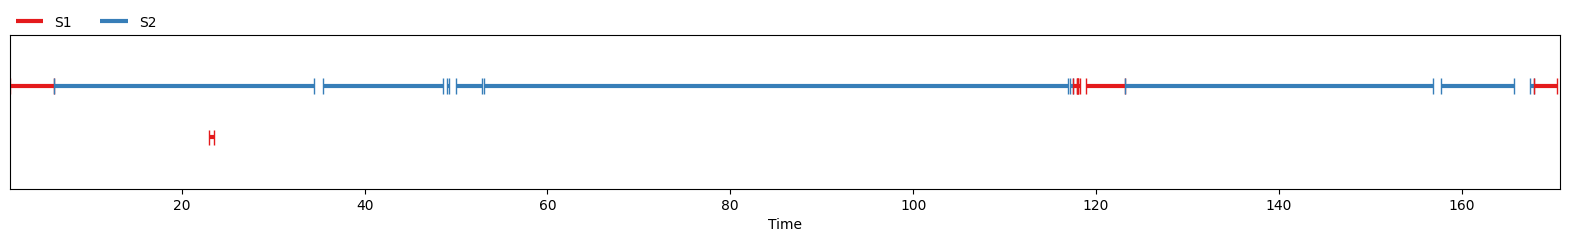

In [ ]:
# Segmentations diarized by the speaker diarization pipeline

file["finetuned pipeline"]

In [ ]:
import librosa
import IPython.display as ipd

speech_file = latest_audio
audio, sample_rate = librosa.load(speech_file)
ipd.display(ipd.Audio(speech_file, rate=sample_rate, embed=True))

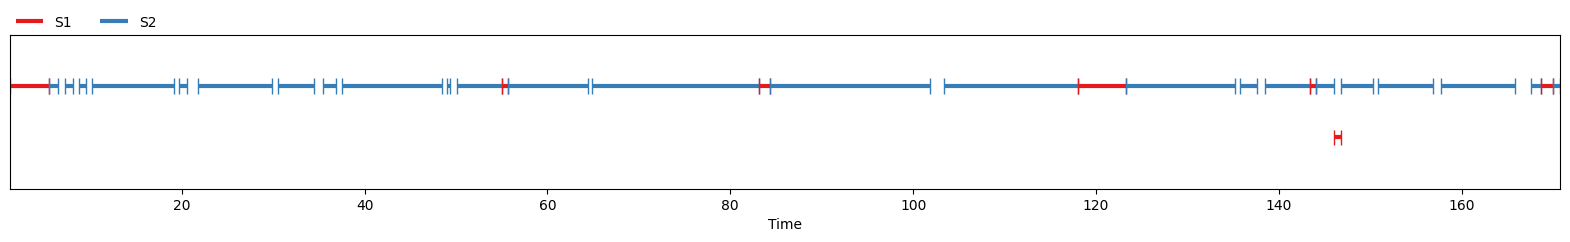

In [ ]:
# Manually annotated segmentations

file["annotation"]

## 7. Exporting Optimized X-Vectors Speaker Diarization Model

The final step is to export the optimized x-vectors speaker diarization model into a file to be reimplemented in other experiments requiring speaker diarization. The output of this step is the optimized model file in the format of a pytorch .pth file.

In [ ]:
import torch

torch.save(finetuned_model.state_dict(), '/optimized_sm_x_vectors_sd_model.pth')

#save a model for each contribution instead of just one

In [ ]:
import pickle
from pyannote.audio import Pipeline

with open("finetuned_pipeline.pkl", "wb") as f:
    pickle.dump(finetuned_pipeline, f)


The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


## 8. References

Mohd Zulhafiz Bin Rahim

*   Postgraduate Student
*   mzhafiz1999@gmail.com

Rahim, M. Z., Juan, S. S., & Mohamad, F. S. (2023). Improving speaker diarization for low-resourced Sarawak Malay language conversational speech corpus. 2023 International Conference on Asian Language Processing (IALP), 228–233. https://doi.org/10.1109/ialp61005.2023.10337314 